# Wind Power Generation Data - Forecasting
https://www.kaggle.com/datasets/mubashirrahim/wind-power-generation-data-forecasting?resource=download

### About the dataset

This dataset is a unique compilation of field-based meteorological observations and wind power generation data, collected directly from one of our company's operational sites. The dataset represents a detailed hourly record, starting from January 2, 2017. This rich dataset provides real-world insights into the interplay between various weather conditions and wind energy production.

### Columns
**Time** - Date and Timestamp of the measurement

**temperature_2m** - Temperature in degrees Fahrenheit at 2 meters above the surface

**relativehumidity_2m** - Relative humidity (as a percentage) at 2 meters above the surface

**dewpoint_2m** - Dew point in degrees Fahrenheit at 2 meters above the surface

**windspeed_10m** - Wind speed in meters per second at 10 meters above the surface

**windspeed_100m** - Wind speed in meters per second at 100 meters above the surface

**winddirection_10m** - Wind direction in degrees (0-360) at 10 meters above the surface (see notes)

**winddirection_100m** - Wind direction in degrees (0-360) at 100 meters above the surface (see notes)

**windgusts_10m** - Wind gusts in meters per second at 100 meters above the surface

**Power** - Turbine output, normalized to be between 0 and 1 (i.e., a percentage of maximum potential output)

In [913]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [914]:
df = pd.read_csv('../Wind Power Generation Data - Forecasting/Location1.csv')
df = df.set_index('Time')
df.index = pd.to_datetime(df.index)

In [915]:
df = df[['temperature_2m', 'relativehumidity_2m', 'dewpoint_2m', 'windspeed_10m',
       'windspeed_100m',
       #'winddirection_10m', 
       #'winddirection_100m',
       'windgusts_10m', 'Power']]

# converting temperature from Fahrenheit to Celcius
df['temperature_2m'] = (df['temperature_2m'] - 32) * 5/9

In [916]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
temperature_2m,43800.0,8.812728,10.807606,-25.777778,0.055556,8.50000,18.055556,34.5000
relativehumidity_2m,43800.0,72.288744,16.852287,18.000000,60.000000,74.00000,86.000000,100.0000
dewpoint_2m,43800.0,38.569308,18.772110,-17.100000,24.300000,38.10000,54.700000,76.3000
windspeed_10m,43800.0,3.591147,1.649318,0.000000,2.410000,3.30000,4.590000,13.4500
windspeed_100m,43800.0,6.284431,2.685216,0.100000,4.380000,6.08000,7.990000,20.6500
windgusts_10m,43800.0,7.771795,3.569147,0.500000,5.000000,7.20000,10.000000,29.2000
Power,43800.0,0.405385,0.288322,0.000000,0.148900,0.34765,0.659600,0.9913


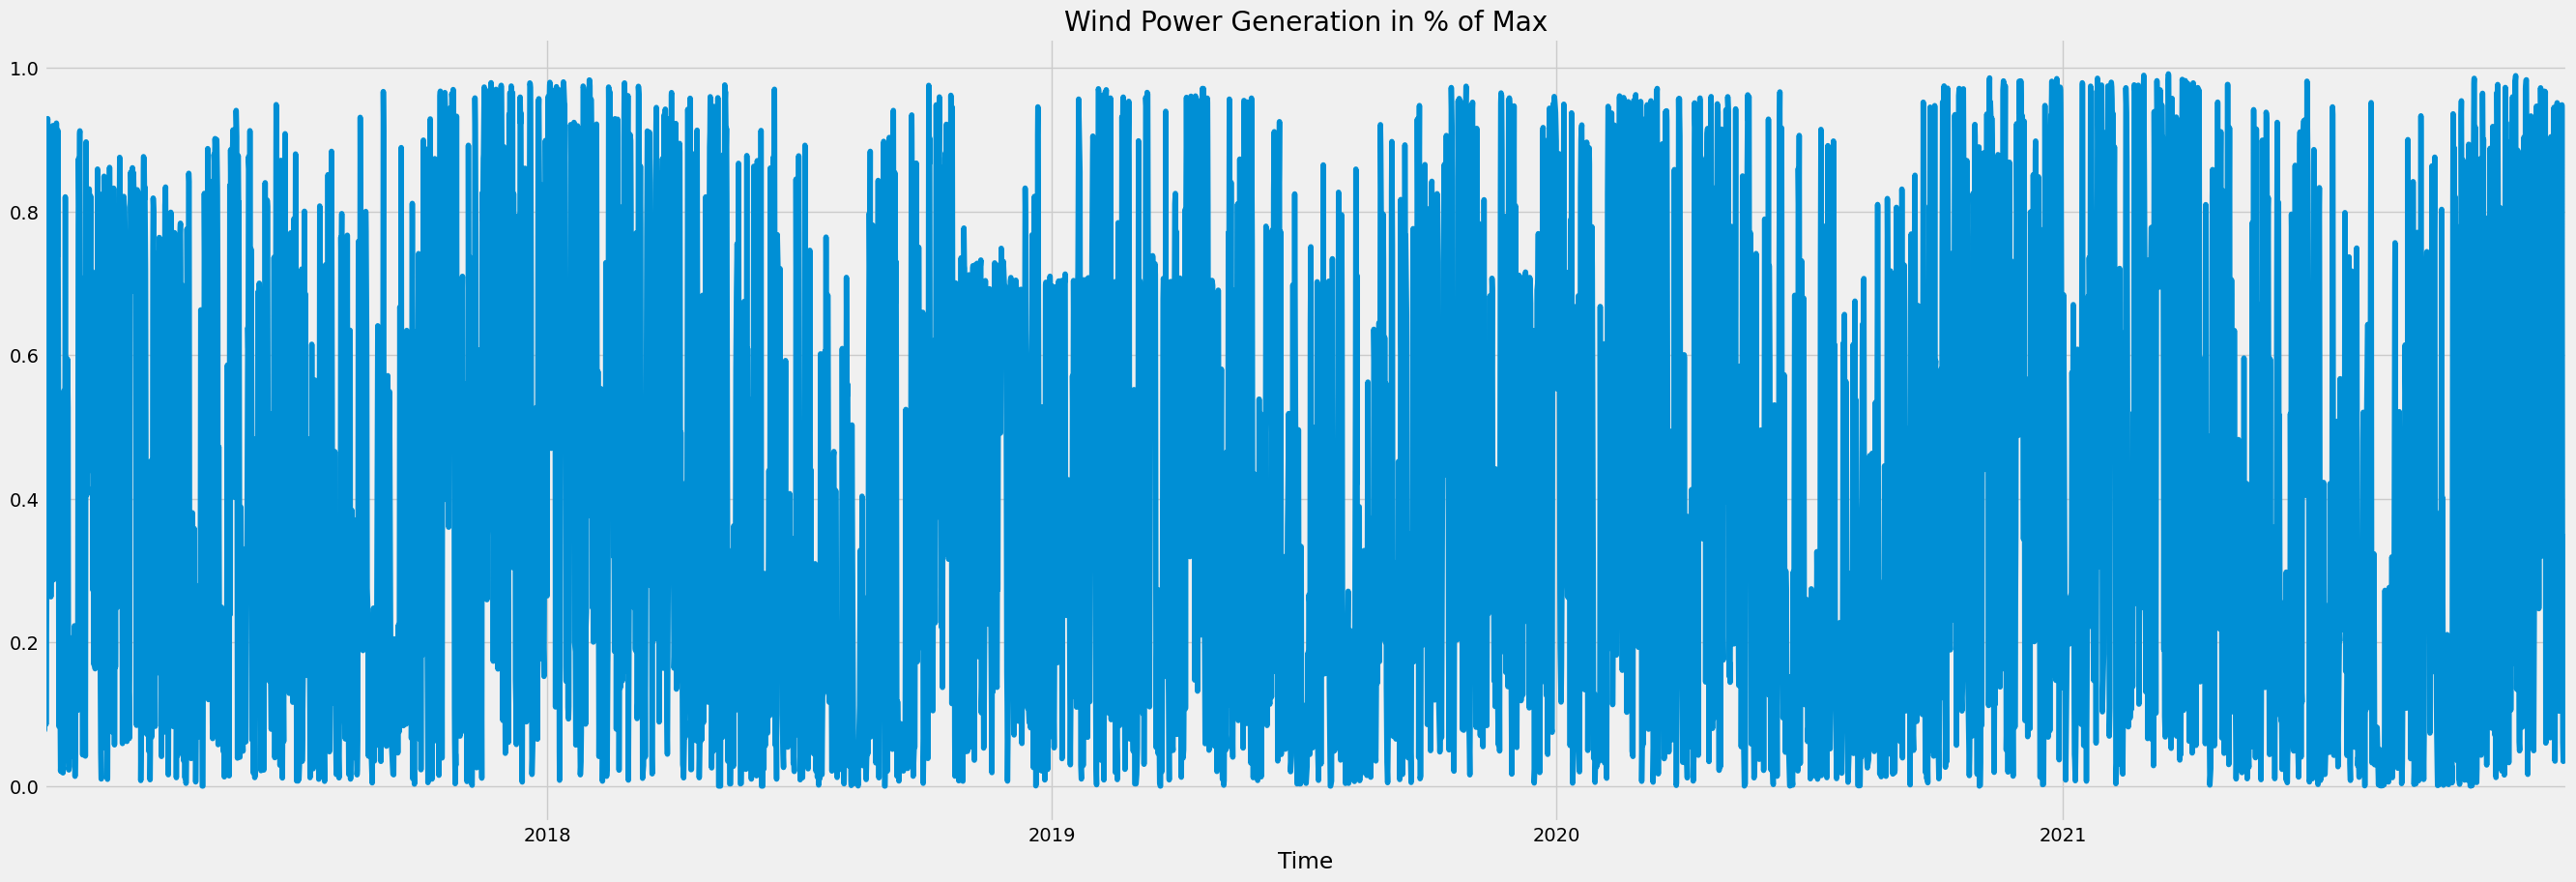

In [917]:
df['Power'].plot(style='-', 
        figsize=(30, 10), 
        color=color_pal[0], 
        title='Wind Power Generation in % of Max')
plt.show()

# Outlier Analysis

<Axes: ylabel='Frequency'>

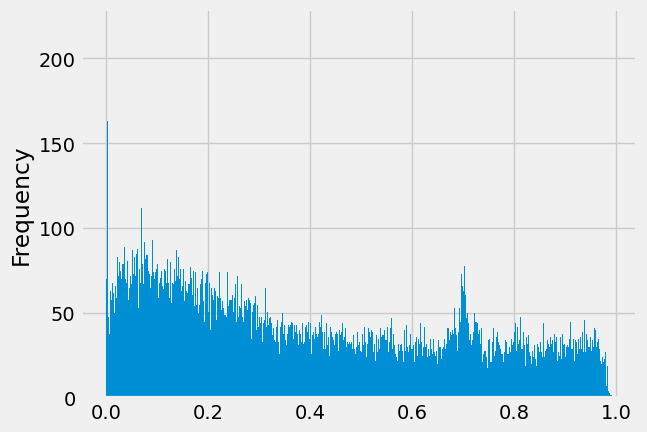

In [918]:
df['Power'].plot(kind='hist', bins=1000)

Suspiciously high amount of near zero values

<Axes: xlabel='Time'>

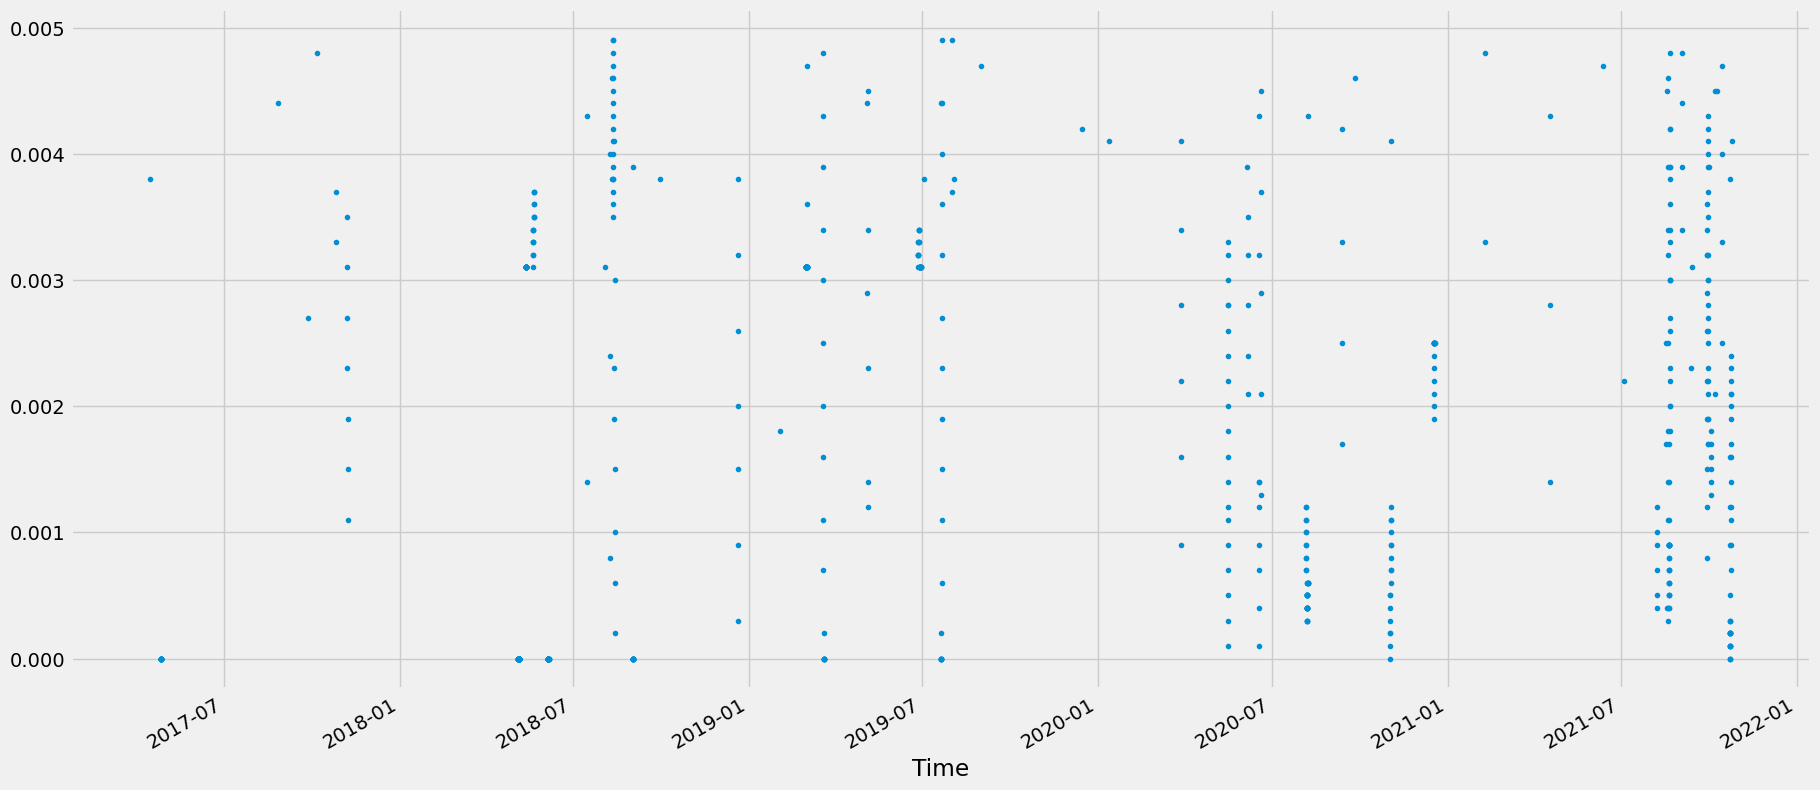

In [919]:
filtered_df = df.query('Power < 0.005')
filtered_df['Power'].plot(figsize=(20, 10), style='.')

### Outlier Conclusion
The distribution of 0.000 values seems to be reasonable since absolutely no wind is a possible scenario.

# Feature Creation

In [920]:
def create_features(df):
    """
    Creating time series features based on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofyear'] = df.index.dayofyear
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

df = create_features(df)

def add_lags(df):
    power_target_map = df['Power'].to_dict()
    #df['power_lag1hour'] = (df.index - pd.Timedelta('1 hours')).map(power_target_map)
    #df['power_lag2hour'] = (df.index - pd.Timedelta('2 hours')).map(power_target_map)
    #df['power_lag3hour'] = (df.index - pd.Timedelta('3 hours')).map(power_target_map)
    df['power_lag1day'] = (df.index - pd.Timedelta('1 days')).map(power_target_map)
    df['power_lag2days'] = (df.index - pd.Timedelta('2 days')).map(power_target_map)
    df['power_lag3days'] = (df.index - pd.Timedelta('3 days')).map(power_target_map)
    #df['power_lag1week'] = (df.index - pd.Timedelta('7 days')).map(power_target_map)
    df['power_lag1year'] = (df.index - pd.Timedelta('365 days')).map(power_target_map)

    windspeed_100m_target_map = df['windspeed_100m'].to_dict()
    df['windspeed_100m_lag1hour'] = (df.index - pd.Timedelta('1 hours')).map(windspeed_100m_target_map)
    df['windspeed_100m_lag2hour'] = (df.index - pd.Timedelta('2 hours')).map(windspeed_100m_target_map)
    df['windspeed_100m_lag3hour'] = (df.index - pd.Timedelta('3 hours')).map(windspeed_100m_target_map)
    #df['windspeed_100m_lag1day'] = (df.index - pd.Timedelta('1 days')).map(windspeed_100m_target_map)
    #df['windspeed_100m_lag2day'] = (df.index - pd.Timedelta('2 days')).map(windspeed_100m_target_map)
    #df['windspeed_100m_lag3day'] = (df.index - pd.Timedelta('3 days')).map(windspeed_100m_target_map)

    windspeed_10m_target_map = df['windspeed_10m'].to_dict()
    #df['windspeed_10m_lag1hour'] = (df.index - pd.Timedelta('1 hours')).map(windspeed_10m_target_map)
    #df['windspeed_10m_lag2hour'] = (df.index - pd.Timedelta('2 hours')).map(windspeed_10m_target_map)
    #df['windspeed_10m_lag3hour'] = (df.index - pd.Timedelta('3 hours')).map(windspeed_10m_target_map)
    #df['windspeed_10m_lag1day'] = (df.index - pd.Timedelta('1 days')).map(windspeed_10m_target_map)
    #df['windspeed_10m_lag2day'] = (df.index - pd.Timedelta('2 days')).map(windspeed_10m_target_map)
    #df['windspeed_10m_lag3day'] = (df.index - pd.Timedelta('3 days')).map(windspeed_10m_target_map)

    temperature_2m_target_map = df['temperature_2m'].to_dict()
    df['windspeed_10m_lag1hour'] = (df.index - pd.Timedelta('1 hours')).map(temperature_2m_target_map)
    #df['windspeed_10m_lag2hour'] = (df.index - pd.Timedelta('2 hours')).map(temperature_2m_target_map)
    #df['windspeed_10m_lag3hour'] = (df.index - pd.Timedelta('3 hours')).map(temperature_2m_target_map)
    #df['windspeed_10m_lag1day'] = (df.index - pd.Timedelta('1 days')).map(temperature_2m_target_map)
    #df['windspeed_10m_lag2day'] = (df.index - pd.Timedelta('2 days')).map(temperature_2m_target_map)
    #df['windspeed_10m_lag3day'] = (df.index - pd.Timedelta('3 days')).map(temperature_2m_target_map)

    relativehumidity_2m_target_map = df['relativehumidity_2m'].to_dict()
    df['relativehumidity_2m_lag1hour'] = (df.index - pd.Timedelta('1 hours')).map(relativehumidity_2m_target_map)
    #df['relativehumidity_2m_lag2hour'] = (df.index - pd.Timedelta('2 hours')).map(relativehumidity_2m_target_map)
    #df['relativehumidity_2m_lag3hour'] = (df.index - pd.Timedelta('3 hours')).map(relativehumidity_2m_target_map)
    #df['relativehumidity_2m_lag1day'] = (df.index - pd.Timedelta('1 days')).map(relativehumidity_2m_target_map)
    #df['relativehumidity_2m_lag2day'] = (df.index - pd.Timedelta('2 days')).map(relativehumidity_2m_target_map)
    #df['relativehumidity_2m_lag3day'] = (df.index - pd.Timedelta('3 days')).map(relativehumidity_2m_target_map)

    windgusts_10m_target_map = df['windgusts_10m'].to_dict()
    df['windgusts_10m_lag1hour'] = (df.index - pd.Timedelta('1 hours')).map(windgusts_10m_target_map)
    #df['windgusts_10m_lag2hour'] = (df.index - pd.Timedelta('2 hours')).map(windgusts_10m_target_map)
    #df['windgusts_10m_lag3hour'] = (df.index - pd.Timedelta('3 hours')).map(windgusts_10m_target_map)
    #df['windgusts_10m_lag1day'] = (df.index - pd.Timedelta('1 days')).map(windgusts_10m_target_map)
    #df['windgusts_10m_lag2day'] = (df.index - pd.Timedelta('2 days')).map(windgusts_10m_target_map)
    #df['windgusts_10m_lag3day'] = (df.index - pd.Timedelta('3 days')).map(windgusts_10m_target_map)

    temperature_2m_target_map = df['temperature_2m'].to_dict()
    df['temperature_2m_lag1hour'] = (df.index - pd.Timedelta('1 hours')).map(temperature_2m_target_map)
    #df['temperature_2m_lag2hour'] = (df.index - pd.Timedelta('2 hours')).map(temperature_2m_target_map)
    #df['temperature_2m_lag3hour'] = (df.index - pd.Timedelta('3 hours')).map(temperature_2m_target_map)
    #df['temperature_2m_lag1day'] = (df.index - pd.Timedelta('1 days')).map(temperature_2m_target_map)
    #df['temperature_2m_lag2day'] = (df.index - pd.Timedelta('2 days')).map(temperature_2m_target_map)
    #df['temperature_2m_lag3day'] = (df.index - pd.Timedelta('3 days')).map(temperature_2m_target_map)

    return df

df = add_lags(df)

In [921]:
df.columns

Index(['temperature_2m', 'relativehumidity_2m', 'dewpoint_2m', 'windspeed_10m',
       'windspeed_100m', 'windgusts_10m', 'Power', 'hour', 'dayofyear',
       'month', 'year', 'power_lag1day', 'power_lag2days', 'power_lag3days',
       'power_lag1year', 'windspeed_100m_lag1hour', 'windspeed_100m_lag2hour',
       'windspeed_100m_lag3hour', 'windspeed_10m_lag1hour',
       'relativehumidity_2m_lag1hour', 'windgusts_10m_lag1hour',
       'temperature_2m_lag1hour'],
      dtype='object')

# Visualizing Feature / Target Relationships

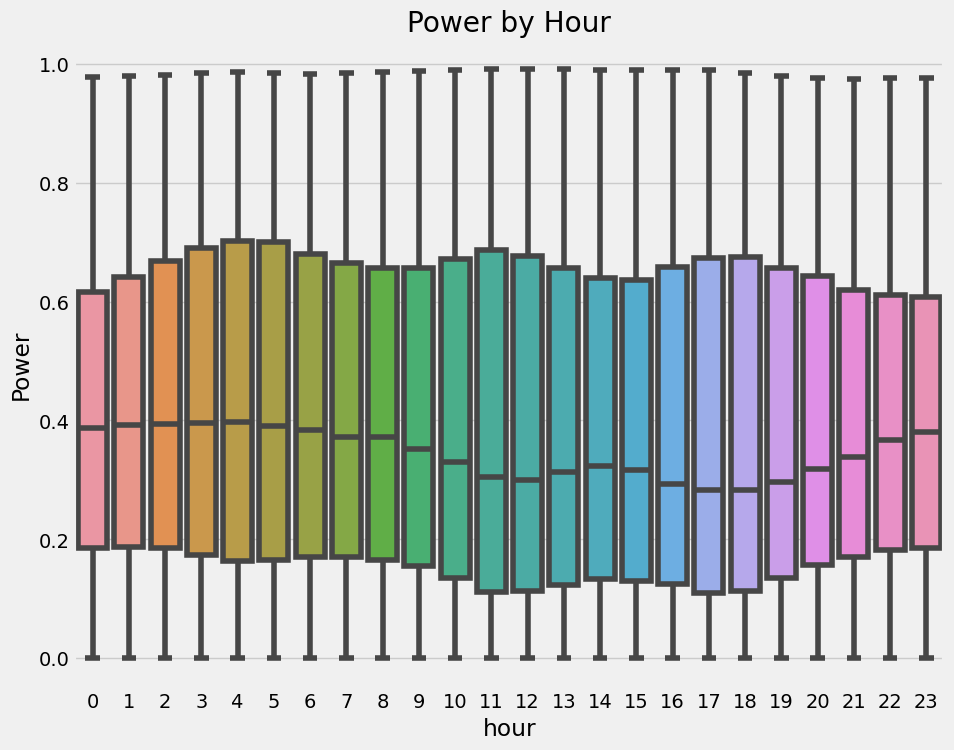

In [922]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='Power')
ax.set_title('Power by Hour')
plt.show()

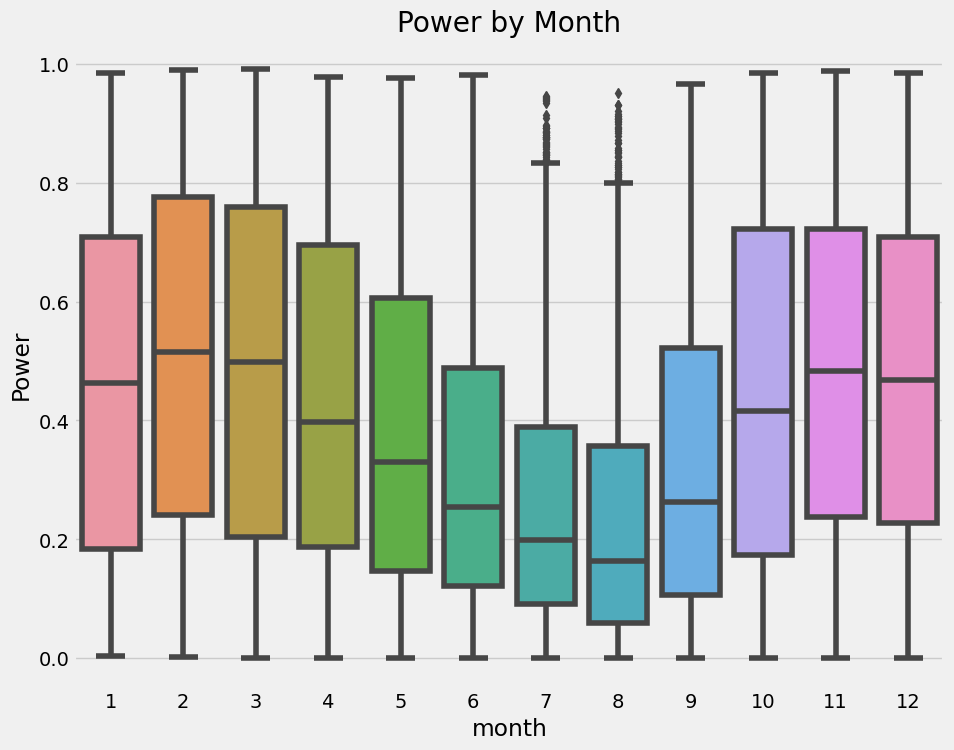

In [923]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Power')
ax.set_title('Power by Month')
plt.show()

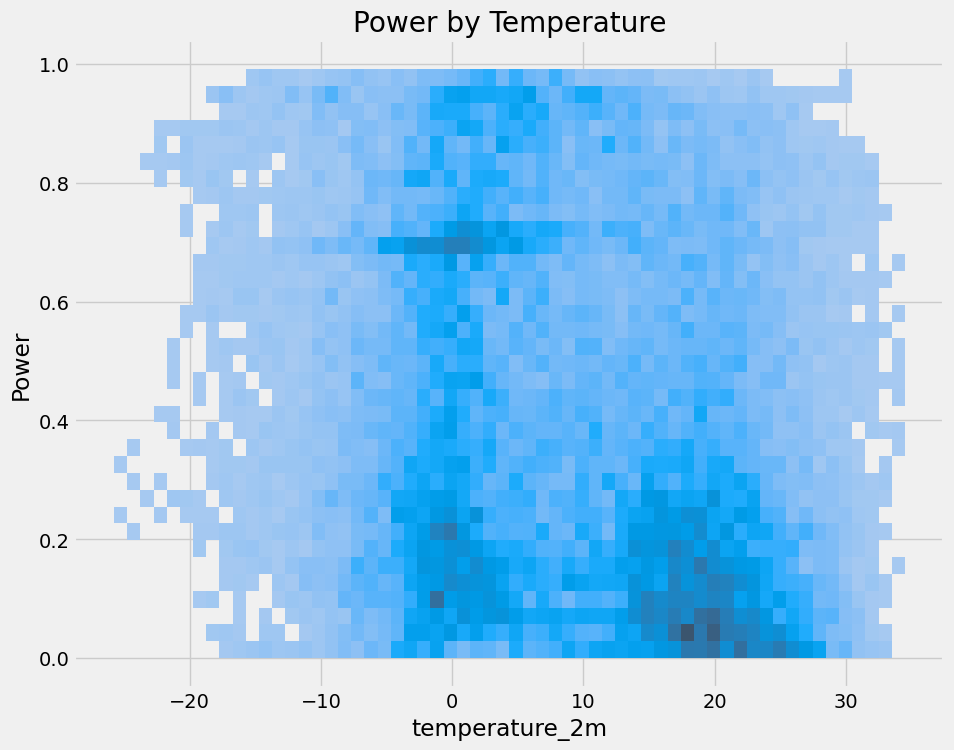

In [924]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=df, x='temperature_2m', y='Power')
ax.set_title('Power by Temperature')
plt.show()

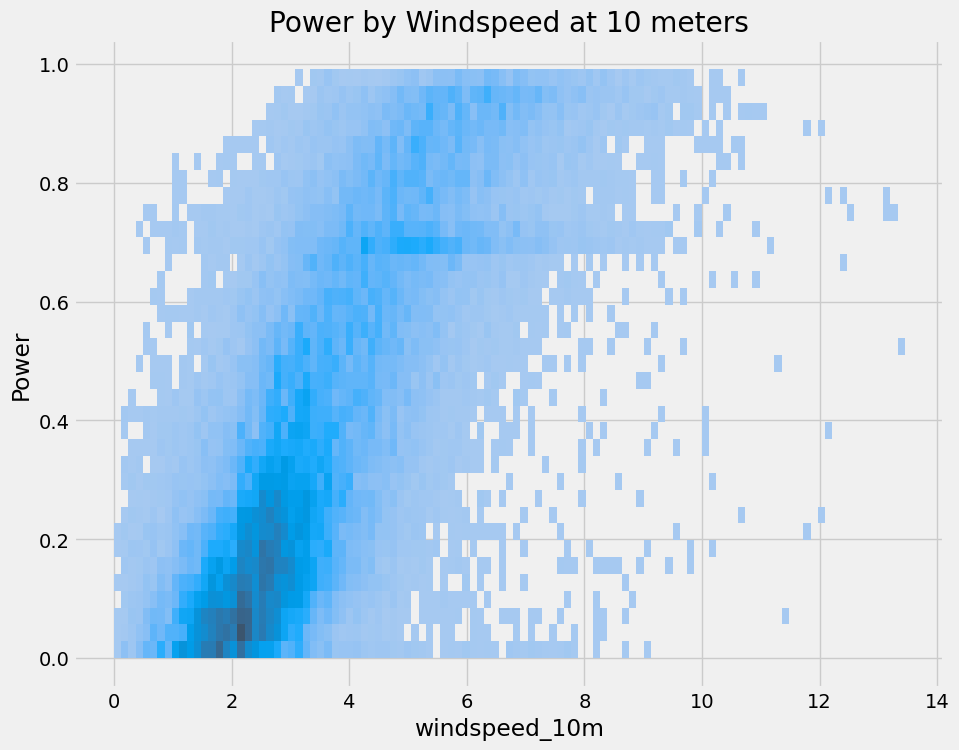

In [925]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=df, x='windspeed_10m', y='Power')
ax.set_title('Power by Windspeed at 10 meters')
plt.show()

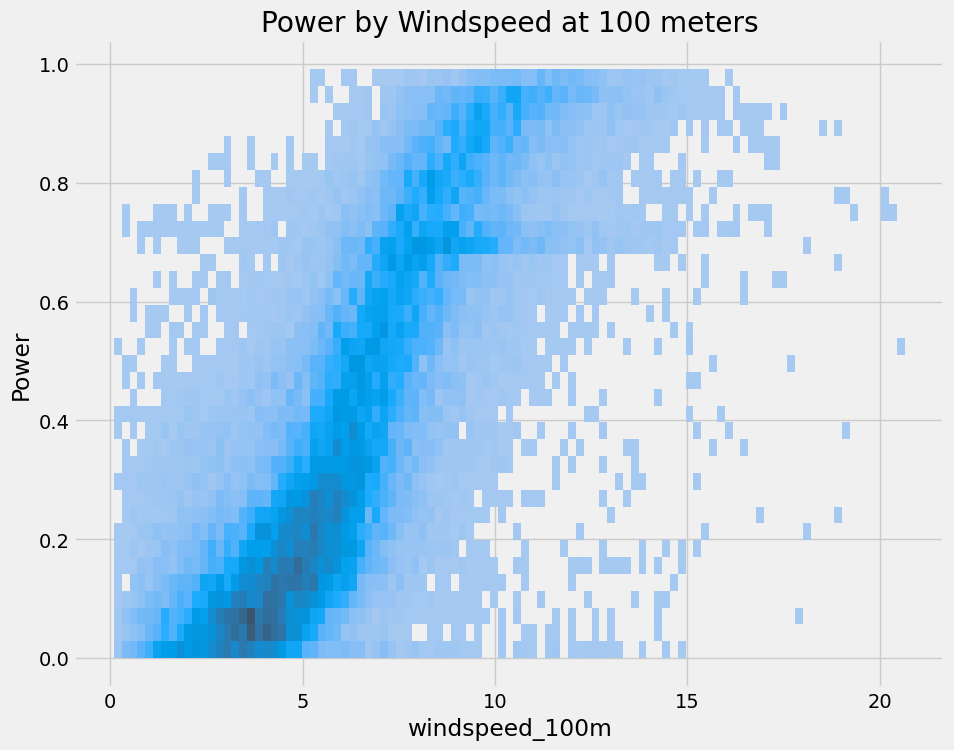

In [926]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=df, x='windspeed_100m', y='Power')
ax.set_title('Power by Windspeed at 100 meters')
plt.show()

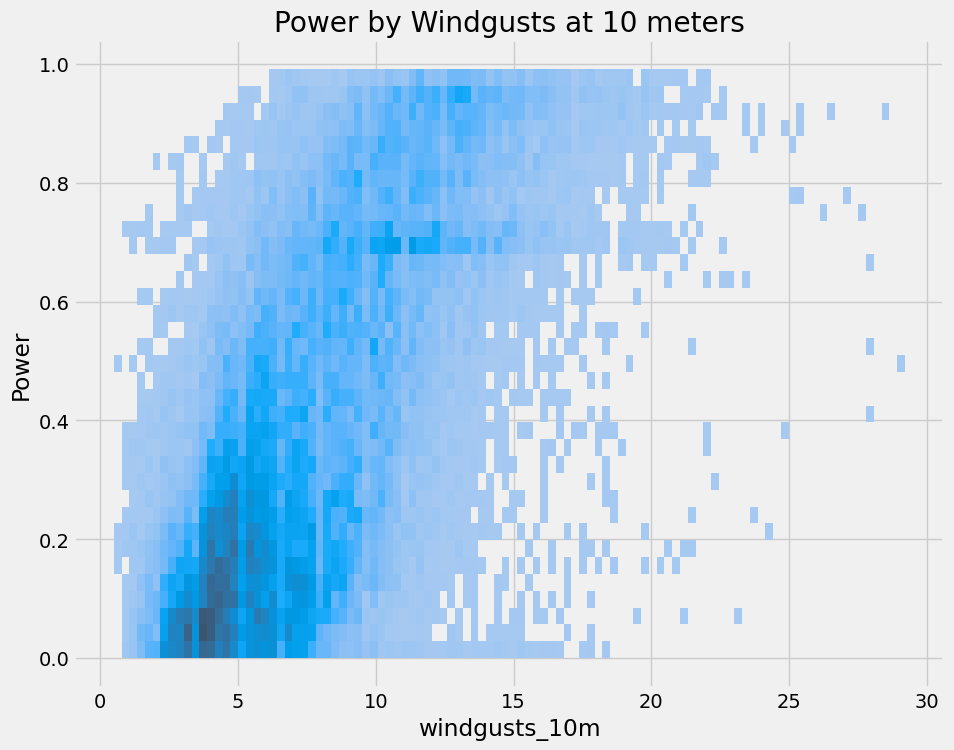

In [927]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=df, x='windgusts_10m', y='Power')
ax.set_title('Power by Windgusts at 10 meters')
plt.show()

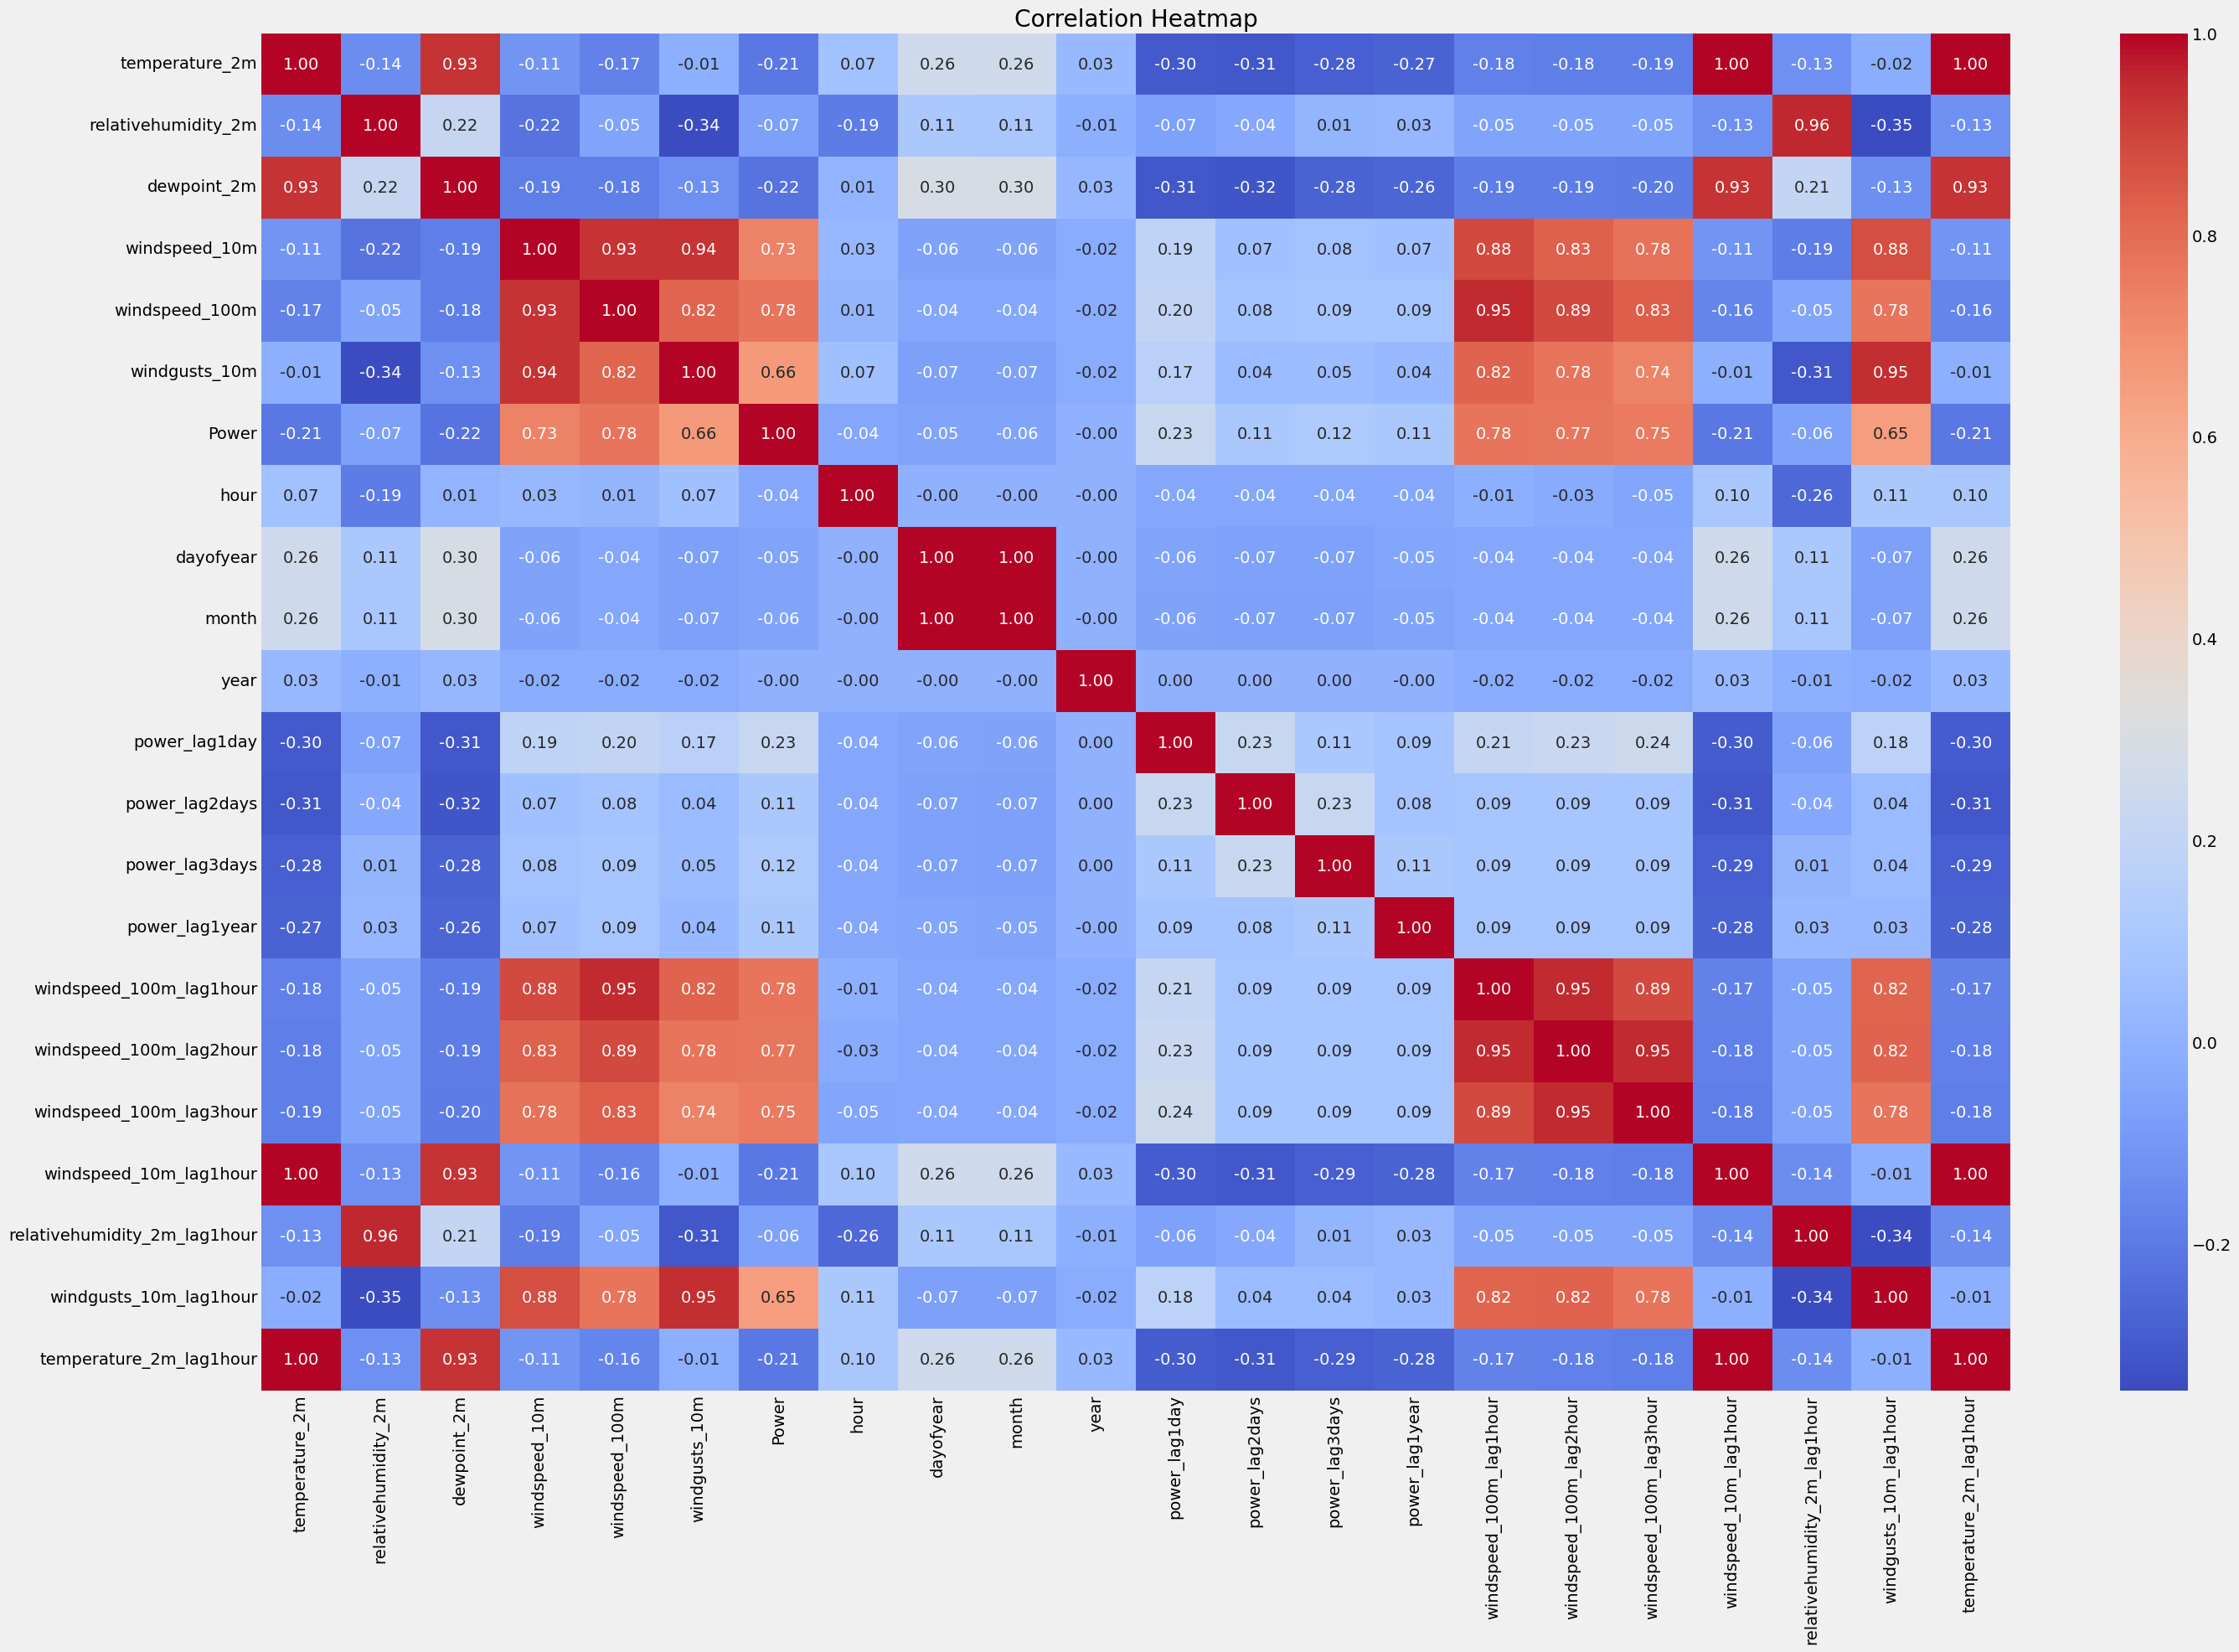

In [928]:
correlation_matrix = df.corr()
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Time Series Cross Validation

In [929]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=24*365*1, gap=24)
df = df.sort_index()

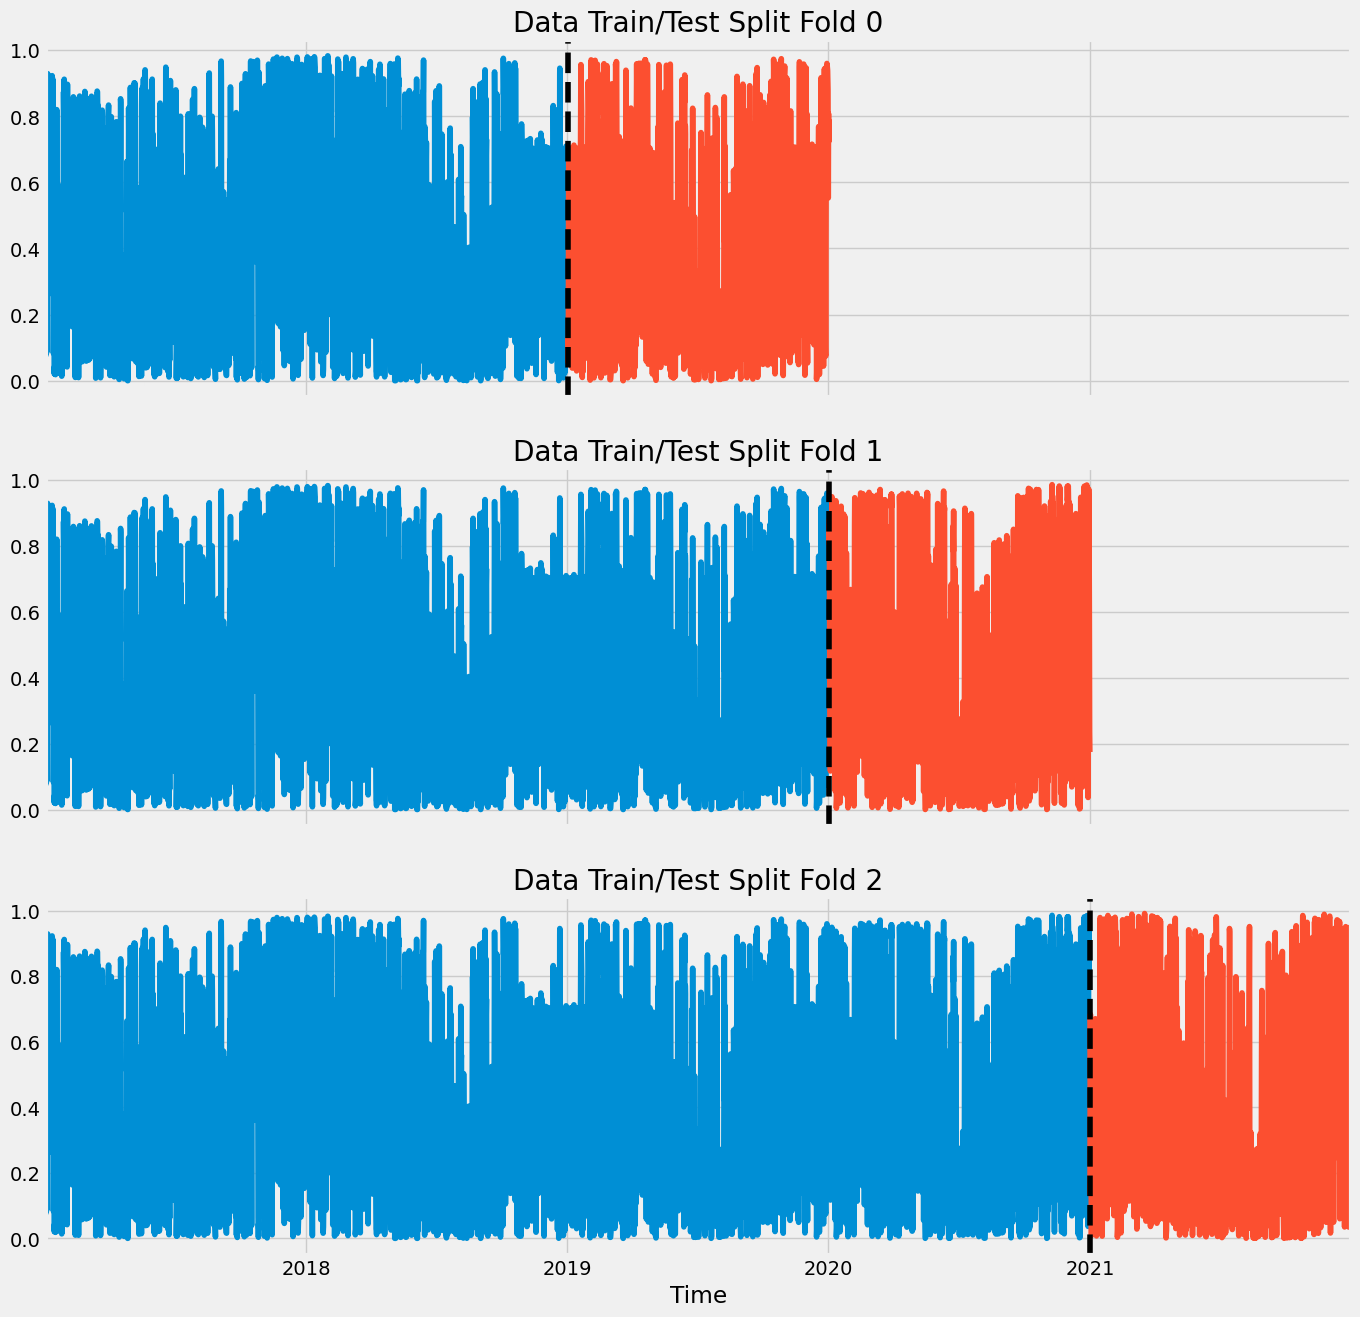

In [930]:
fig, axs = plt.subplots(3, 1, figsize=(15, 15),
                        sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['Power'].plot(ax=axs[fold], 
                          label='Training Set', 
                          title=f'Data Train/Test Split Fold {fold}')
    test['Power'].plot(ax=axs[fold], 
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

plt.show()

# Training the Model

In [931]:
tss = TimeSeriesSplit(n_splits=3, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = [
                #'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m', 'windspeed_10m',
                #'windspeed_100m', 'windgusts_10m', 
                'hour', 
                #'dayofyear', 'month', 'year', 
                #'power_lag1hour', 'power_lag2hour', 'power_lag3hour',
                #'power_lag1day', 'power_lag2days', 'power_lag3days', 'power_lag1week', 'power_lag1year', 
                'windspeed_100m_lag1hour', 'windspeed_100m_lag2hour', 'windspeed_100m_lag3hour', 
                #'windspeed_100m_lag1day', 'windspeed_100m_lag2day', 'windspeed_100m_lag3day',
                #'windspeed_10m_lag1hour', 'windspeed_10m_lag2hour', 'windspeed_10m_lag3hour', 
                #'windspeed_10m_lag1day', 'windspeed_10m_lag2day', 'windspeed_10m_lag3day',
                #'relativehumidity_2m_lag1hour', 'relativehumidity_2m_lag2hour', 'relativehumidity_2m_lag3hour', 
                #'relativehumidity_2m_lag1day', 'relativehumidity_2m_lag2day', 'relativehumidity_2m_lag3day',
                #'windgusts_10m_lag1hour', 'windgusts_10m_lag2hour', 'windgusts_10m_lag3hour', 
                #'windgusts_10m_lag1day', 'windgusts_10m_lag2day', 'windgusts_10m_lag3day',
                #'temperature_2m_lag1hour', 'temperature_2m_lag2hour', 'temperature_2m_lag3hour', 
                #'temperature_2m_lag1day', 'temperature_2m_lag2day', 'temperature_2m_lag3day'
                ]
    TARGET = 'Power'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=3000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:0.29768	validation_1-rmse:0.29671
[100]	validation_0-rmse:0.18898	validation_1-rmse:0.18495


/Users/janstein/anaconda3/envs/myenv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [16:17:54] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.16687	validation_1-rmse:0.16156
[300]	validation_0-rmse:0.16278	validation_1-rmse:0.15714
[400]	validation_0-rmse:0.16178	validation_1-rmse:0.15618
[500]	validation_0-rmse:0.16132	validation_1-rmse:0.15584
[600]	validation_0-rmse:0.16092	validation_1-rmse:0.15562
[700]	validation_0-rmse:0.16060	validation_1-rmse:0.15553
[800]	validation_0-rmse:0.16033	validation_1-rmse:0.15550
[900]	validation_0-rmse:0.16008	validation_1-rmse:0.15547
[1000]	validation_0-rmse:0.15982	validation_1-rmse:0.15544
[1100]	validation_0-rmse:0.15955	validation_1-rmse:0.15534
[1200]	validation_0-rmse:0.15931	validation_1-rmse:0.15529
[1300]	validation_0-rmse:0.15908	validation_1-rmse:0.15527
[1400]	validation_0-rmse:0.15887	validation_1-rmse:0.15524
[1500]	validation_0-rmse:0.15866	validation_1-rmse:0.15520
[1600]	validation_0-rmse:0.15844	validation_1-rmse:0.15519
[1700]	validation_0-rmse:0.15824	validation_1-rmse:0.15518
[1741]	validation_0-rmse:0.15817	validation_1-rmse:0.15518
[0]	v

/Users/janstein/anaconda3/envs/myenv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [16:17:56] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.16465	validation_1-rmse:0.16363
[300]	validation_0-rmse:0.16046	validation_1-rmse:0.15874
[400]	validation_0-rmse:0.15937	validation_1-rmse:0.15746
[500]	validation_0-rmse:0.15893	validation_1-rmse:0.15705
[600]	validation_0-rmse:0.15860	validation_1-rmse:0.15687
[700]	validation_0-rmse:0.15838	validation_1-rmse:0.15679
[800]	validation_0-rmse:0.15816	validation_1-rmse:0.15678
[804]	validation_0-rmse:0.15816	validation_1-rmse:0.15677
[0]	validation_0-rmse:0.29881	validation_1-rmse:0.31147
[100]	validation_0-rmse:0.18713	validation_1-rmse:0.19529


/Users/janstein/anaconda3/envs/myenv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [16:17:57] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.16411	validation_1-rmse:0.16923
[300]	validation_0-rmse:0.15986	validation_1-rmse:0.16367
[400]	validation_0-rmse:0.15879	validation_1-rmse:0.16221
[500]	validation_0-rmse:0.15838	validation_1-rmse:0.16182
[600]	validation_0-rmse:0.15811	validation_1-rmse:0.16166
[700]	validation_0-rmse:0.15790	validation_1-rmse:0.16162
[800]	validation_0-rmse:0.15770	validation_1-rmse:0.16158
[900]	validation_0-rmse:0.15754	validation_1-rmse:0.16156
[1000]	validation_0-rmse:0.15739	validation_1-rmse:0.16152
[1100]	validation_0-rmse:0.15723	validation_1-rmse:0.16148
[1200]	validation_0-rmse:0.15706	validation_1-rmse:0.16142
[1300]	validation_0-rmse:0.15692	validation_1-rmse:0.16140
[1400]	validation_0-rmse:0.15676	validation_1-rmse:0.16134
[1500]	validation_0-rmse:0.15662	validation_1-rmse:0.16133
[1583]	validation_0-rmse:0.15653	validation_1-rmse:0.16132


In [932]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.1578
Fold scores:[0.15517535224115828, 0.15675991576602177, 0.16131907372929727]


# Feature Importance

In [933]:
fi = pd.DataFrame(data=reg.feature_importances_, 
                  index=reg.feature_names_in_,
                  columns=['importance'])

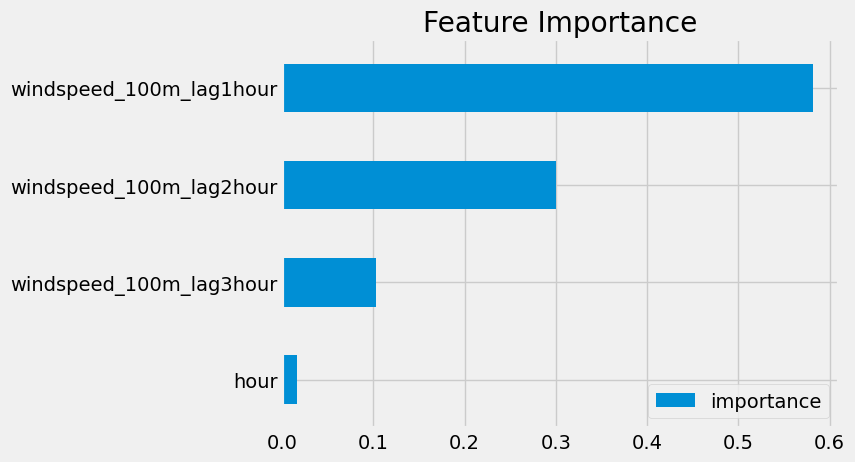

In [934]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecasting on Test

In [935]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

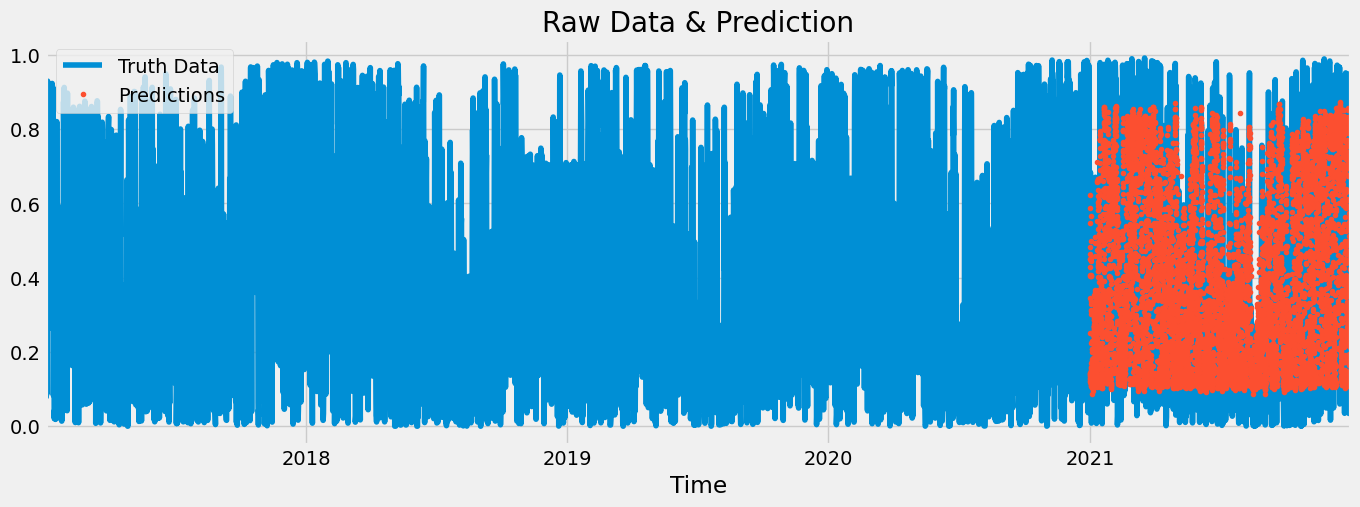

In [936]:
ax = df[['Power']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data & Prediction')
plt.show()

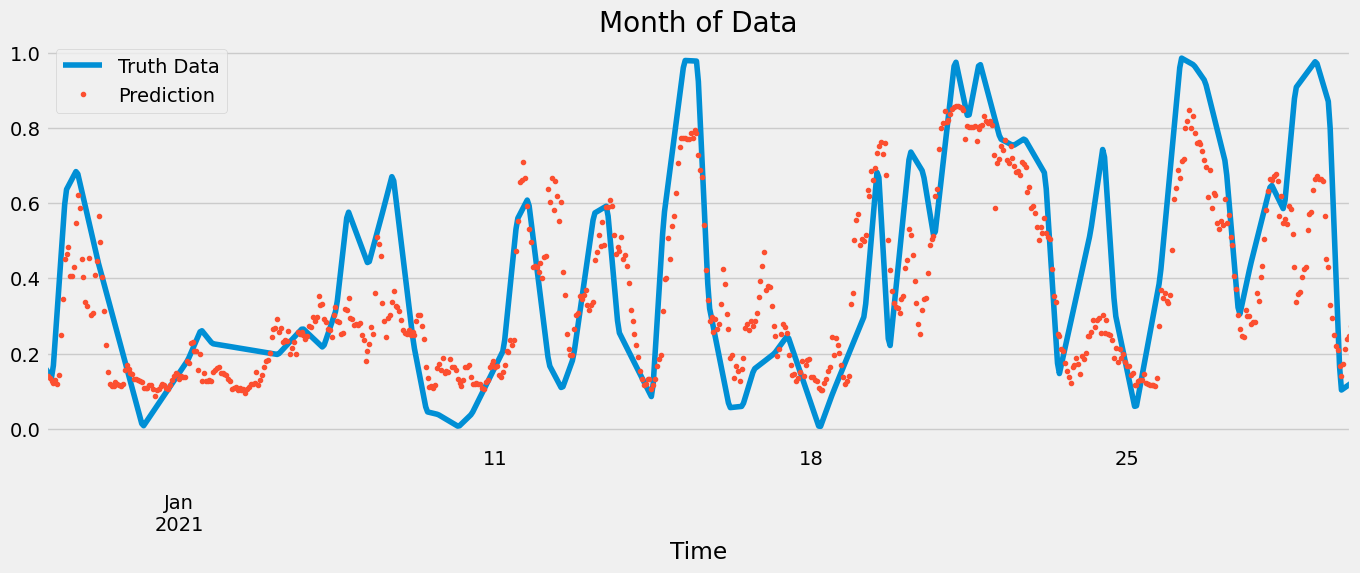

In [937]:
ax = df.loc[(df.index > '01-01-2021') & (df.index < '01-30-2021')]['Power'].plot(figsize=(15, 5), title='Month of Data', style='-')
df.loc[(df.index > '01-01-2021') & (df.index < '01-30-2021')]['prediction'].plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [938]:
score = np.sqrt(mean_squared_error(test['Power'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.4f}')

RMSE Score on Test set: 0.1613


In [939]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date

In [940]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head(10)

date
2021-12-24    0.414632
2021-03-13    0.374698
2021-04-05    0.308981
2021-05-19    0.283588
2021-08-01    0.276732
2021-04-25    0.274187
2021-03-24    0.273660
2021-12-16    0.267111
2021-02-15    0.266468
2021-10-14    0.265405
Name: error, dtype: float64

In [941]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(10)

date
2021-01-06    0.031788
2021-07-17    0.039243
2021-09-01    0.040340
2021-09-02    0.044041
2021-07-08    0.044467
2021-10-12    0.047386
2021-12-08    0.047860
2021-11-04    0.048473
2021-01-03    0.048544
2021-12-19    0.049713
Name: error, dtype: float64